### Citation

The training part is from:

François Chollet (2020) The most modern way to implement a WGAN-GP in Keras https://github.com/keras-team/keras-io/blob/master/examples/generative/wgan_gp.py

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from numpy.random import randint
from tqdm import tqdm
import os

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np


ds = tfds.load('div2k/bicubic_x4')
train_ds = ds['train']

#train_ds_hr, train_ds_lr= tfds.load('div2k/bicubic_x4', split='train',batch_size=-1,as_supervised=True)

In [ ]:
def crop_image(example):
    img_crop = [100, 100, 384, 384]
    img = example['hr']
    hr_patch = tf.image.crop_to_bounding_box(img, img_crop[0],
                                                  img_crop[1],
                                                  img_crop[2],
                                                  img_crop[3])
    hr_patch = tf.cast(hr_patch, tf.float32) / (255. / 2.)
    #hr_patch = hr_patch - 1.
    lr_patch = tf.image.resize(hr_patch, size=[96, 96])
    return lr_patch, hr_patch

In [ ]:
cropped_img = train_ds.map(crop_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache()

In [ ]:
cropped_img_input = cropped_img.repeat().batch(8)

In [ ]:
cropped_img_input

<BatchDataset shapes: ((None, 96, 96, 3), (None, 384, 384, 3)), types: (tf.float32, tf.float32)>

In [ ]:
inputs = tf.keras.Input(shape=(96, 96, 3)) # Model to 2x the image
x = inputs
x = tf.keras.layers.Conv2D(64, 9, padding='same')(x)
x = tf.keras.layers.PReLU()(x)
c1 = x

x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.PReLU()(x)
x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Add()([c1, x])
c2 = x

x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.PReLU()(x)
x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Add()([c2, x])
c3 = x

x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.PReLU()(x)
x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Add()([c3, x])
c4 = x

x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.PReLU()(x)
x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Add()([c4, x])
c5 = x

x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.PReLU()(x)
x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Add()([c5, x])
c6 = x

x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Add()([c1, x])

x = tf.keras.layers.Conv2D(256, 3, padding='same')(x)
x = tf.keras.layers.Lambda(lambda x: tf.nn.depth_to_space(x, 2))(x)
x = tf.keras.layers.PReLU()(x)

x = tf.keras.layers.Conv2D(256, 3, padding='same')(x)
x = tf.keras.layers.Lambda(lambda x: tf.nn.depth_to_space(x, 2))(x)
x = tf.keras.layers.PReLU()(x)

x = tf.keras.layers.Conv2D(3, 9, padding='same')(x)
output = x
model = tf.keras.Model(inputs, output)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 96, 64)   15616       input_1[0][0]                    
__________________________________________________________________________________________________
p_re_lu (PReLU)                 (None, 96, 96, 64)   589824      conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 96, 96, 64)   36928       p_re_lu[0][0]                    
_______________________________________________________________________________________

In [ ]:
#model.compile(optimizer='adam', loss='mse')
#model.fit(cropped_img_input, steps_per_epoch=1000, epochs=1)

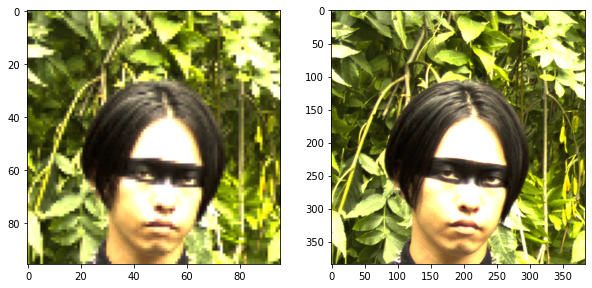

In [ ]:
cropped_img_iter = iter(cropped_img_input)
val_cropped_img = next(cropped_img_iter)
fig, axes = plt.subplots(1,2, figsize=(10,10))
axes[0].imshow(tf.squeeze(val_cropped_img[0][0]))
axes[1].imshow(tf.squeeze(val_cropped_img[1][0]))

In [ ]:
np.max(val_cropped_img[1][0])

2.0

In [ ]:
inputs_d = tf.keras.Input(shape=(384, 384, 3)) # Discriminator Model
x_d = inputs_d
x_d = tf.keras.layers.Conv2D(64, 3, strides=2, padding='same')(x_d)
x_d = tf.keras.layers.LeakyReLU(alpha=0.2)(x_d)

x_d = tf.keras.layers.Conv2D(64, 3, strides=2, padding='same')(x_d)
x_d = tf.keras.layers.BatchNormalization()(x_d)
x_d = tf.keras.layers.LeakyReLU(alpha=0.2)(x_d)

x_d = tf.keras.layers.Conv2D(128, 3, strides=1, padding='same')(x_d)
x_d = tf.keras.layers.BatchNormalization()(x_d)
x_d = tf.keras.layers.LeakyReLU(alpha=0.2)(x_d)

x_d = tf.keras.layers.Conv2D(128, 3, strides=2, padding='same')(x_d)
x_d = tf.keras.layers.BatchNormalization()(x_d)
x_d = tf.keras.layers.LeakyReLU(alpha=0.2)(x_d)

x_d = tf.keras.layers.Conv2D(256, 3, strides=1, padding='same')(x_d)
x_d = tf.keras.layers.BatchNormalization()(x_d)
x_d = tf.keras.layers.LeakyReLU(alpha=0.2)(x_d)

x_d = tf.keras.layers.Conv2D(256, 3, strides=2, padding='same')(x_d)
x_d = tf.keras.layers.BatchNormalization()(x_d)
x_d = tf.keras.layers.LeakyReLU(alpha=0.2)(x_d)

x_d = tf.keras.layers.Conv2D(512, 3, strides=1, padding='same')(x_d)
x_d = tf.keras.layers.BatchNormalization()(x_d)
x_d = tf.keras.layers.LeakyReLU(alpha=0.2)(x_d)

x_d = tf.keras.layers.Conv2D(512, 3, strides=2, padding='same')(x_d)
x_d = tf.keras.layers.BatchNormalization()(x_d)
x_d = tf.keras.layers.LeakyReLU(alpha=0.2)(x_d)

x_d = tf.keras.layers.Conv2D(512, 3, strides=1, padding='same')(x_d)
x_d = tf.keras.layers.BatchNormalization()(x_d)
x_d = tf.keras.layers.LeakyReLU(alpha=0.2)(x_d)

x_d = tf.keras.layers.Conv2D(512, 3, strides=2, padding='same')(x_d)
x_d = tf.keras.layers.BatchNormalization()(x_d)
x_d = tf.keras.layers.LeakyReLU(alpha=0.2)(x_d)

x_d = tf.keras.layers.Flatten()(x_d)
x_d = tf.keras.layers.Dense(1024)(x_d)
x_d = tf.keras.layers.LeakyReLU(alpha=0.2)(x_d)
x_d = tf.keras.layers.Dense(1, activation='sigmoid')(x_d)
output_d = x_d
model_d = tf.keras.Model(inputs_d, output_d)
model_d.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 384, 384, 3)]     0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 192, 192, 64)      1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 192, 192, 64)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 96, 96, 64)        36928     
_________________________________________________________________
batch_normalization_11 (Batc (None, 96, 96, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 96, 96, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 96, 96, 128)      

In [ ]:
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss

In [ ]:
class GAN(tf.keras.Model):
  def __init__(self, discriminator, generator):
    super(GAN, self).__init__()
    self.discriminator = discriminator
    self.generator = generator
    global d_loss_list
    global g_loss_list
    global recon_loss_list



  def compile(self, 
              d_optimizer, 
              g_optimizer, 
              loss_fn, 
              recon_loss_fn, 
              loss_weights=[1,1,1]):
    super(GAN, self).compile()
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.loss_fn = loss_fn
    self.recon_loss_fn = recon_loss_fn
    self.loss_weights = loss_weights

  def gradient_penalty(self, batch_size, real_images, fake_images):
    """ Calculates the gradient penalty.

    This loss is calculated on an interpolated image
    and added to the discriminator loss.
    """
    # get the interplated image
    alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
    diff = fake_images - real_images
    interpolated = real_images + alpha * diff

    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        # 1. Get the discriminator output for this interpolated image.
        pred = self.discriminator(interpolated, training=True)

    # 2. Calculate the gradients w.r.t to this interpolated image.
    grads = gp_tape.gradient(pred, [interpolated])[0]
    # 3. Calcuate the norm of the gradients
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
    gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp

  def train_step(self, data):
    input_images, real_images = data  #? what is the type of data, and it's shape
    batch_size = tf.shape(real_images)[0] # 
    #print(batch_size)
    generated_images = self.generator(input_images)
    combined_images = tf.concat([generated_images, real_images], axis=0)
    labels = tf.concat([tf.ones((batch_size, 1)),
                        -tf.ones((batch_size, 1))], axis=0)
    labels += 0.05 * tf.random.uniform(tf.shape(labels))
    #print(tf.shape(combined_images))
    with tf.GradientTape() as tape:
      noise_concat = tf.concat([tf.random.normal(shape=tf.shape(generated_images), mean=0.0, stddev=0.1, dtype=tf.float32),
                                tf.zeros(shape=tf.shape(real_images))], axis=0)
      noisy_image =combined_images + noise_concat
      predictions = self.discriminator(noisy_image)
      d_loss = self.loss_fn(labels, predictions)
      rl_img, fk_img = tf.split(noisy_image, num_or_size_splits=2, axis=0)
      #gp = self.gradient_penalty(batch_size, rl_img, fk_img)
      d_loss =d_loss*self.loss_weights[0]
    grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
    self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

    with tf.GradientTape() as tape:
      generated_images = self.generator(input_images)
      predictions = self.discriminator(generated_images)
      g_loss = self.loss_fn(-tf.ones((batch_size, 1)), predictions)
      recon_loss = self.recon_loss_fn(real_images, generated_images)
      loss = g_loss*self.loss_weights[1] + recon_loss*self.loss_weights[2]
    grads = tape.gradient(loss, self.generator.trainable_weights)
    self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
    psnr = tf.image.psnr(generated_images, real_images, max_val=2.0)
    ssim = tf.image.ssim(generated_images, real_images, max_val=2.0, filter_size=11,filter_sigma=1.5, k1=0.01, k2=0.03)
    return { 'd_loss': d_loss, 'g_loss': g_loss, 'recon_loss': recon_loss, 'PSNR':psnr, 'SSIM':ssim}

gan_model = GAN(model_d, model)
gan_model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001), 
                  tf.keras.optimizers.Adam(learning_rate=0.0001), 
                  lambda y,x: discriminator_loss(y,x), 
                  lambda y,x: tf.reduce_mean(tf.keras.losses.mean_squared_error(y,x)),
                  loss_weights=[1,10, 1])


In [ ]:
history = gan_model.fit(cropped_img_input, steps_per_epoch=50, epochs=20)

Epoch 1/20
50/50 [==============================] - 11s 222ms/step - d_loss: -0.0242 - g_loss: 1.0000 - recon_loss: 0.0092 - PSNR: 31.4380 - SSIM: 0.8157
Epoch 2/20
50/50 [==============================] - 11s 222ms/step - d_loss: -0.0250 - g_loss: 1.0000 - recon_loss: 0.0079 - PSNR: 31.5376 - SSIM: 0.8293
Epoch 3/20
50/50 [==============================] - 11s 223ms/step - d_loss: -0.0242 - g_loss: 1.0000 - recon_loss: 0.0092 - PSNR: 31.5066 - SSIM: 0.8163
Epoch 4/20
50/50 [==============================] - 11s 222ms/step - d_loss: -0.0249 - g_loss: 1.0000 - recon_loss: 0.0080 - PSNR: 31.3895 - SSIM: 0.8289
Epoch 5/20
50/50 [==============================] - 11s 223ms/step - d_loss: -0.0248 - g_loss: 1.0000 - recon_loss: 0.0092 - PSNR: 31.3937 - SSIM: 0.8154
Epoch 6/20
50/50 [==============================] - 11s 222ms/step - d_loss: -0.0245 - g_loss: 1.0000 - recon_loss: 0.0083 - PSNR: 30.6637 - SSIM: 0.8266
Epoch 7/20
50/50 [==============================] - 11s 222ms/step - d_loss:

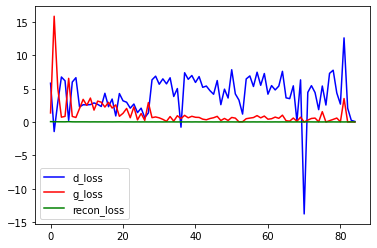

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['d_loss'][:85],color = 'b', label = "d_loss")
plt.plot(history.history['g_loss'][:85],color = 'r', label = "g_loss")
plt.plot(history.history['recon_loss'][:85],color = 'g', label = "recon_loss")
plt.legend()

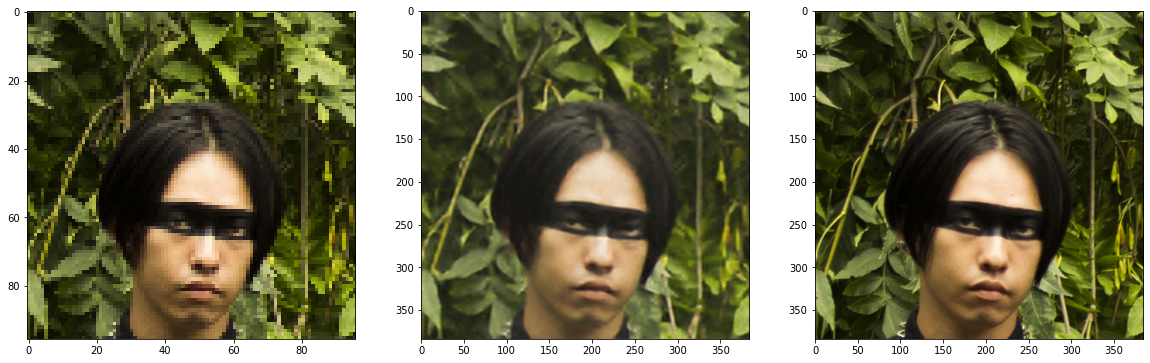

In [ ]:
fakes = model.predict(val_cropped_img[0])
fig, axes = plt.subplots(1,3, figsize=(20,20))
ds = np.squeeze(val_cropped_img[0][0].numpy())
us = np.squeeze(fakes[0])
ori = np.squeeze(val_cropped_img[1][0])
ds = (ds - ds.min()) / (ds.max() - ds.min())
us = (us - us.min()) / (us.max() - us.min())
ori = (ori - ori.min()) / (ori.max() - ori.min())
axes[0].imshow(ds,cmap='gray')
axes[1].imshow(us,cmap='gray')
axes[2].imshow(ori,cmap='gray')
plt.savefig('150epoch_wgan.png')

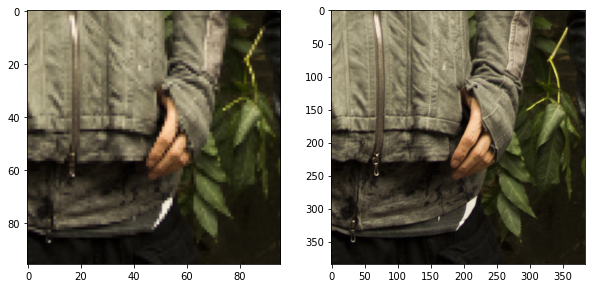

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(10,10))
ds = np.squeeze(val_cropped_img[0][0].numpy())
us = np.squeeze(val_cropped_img[1][0])
ds = (ds - ds.min()) / (ds.max() - ds.min())
us = (us - us.min()) / (us.max() - us.min())
axes[0].imshow(ds)
axes[1].imshow(us)

# stop here

## GAN

In [ ]:
class GAN(tf.keras.Model):
  def __init__(self, discriminator, generator):
    super(GAN, self).__init__()
    self.discriminator = discriminator
    self.generator = generator

  def compile(self, 
              d_optimizer, 
              g_optimizer, 
              loss_fn, 
              recon_loss_fn, 
              loss_weights=[1,1,1]):
    super(GAN, self).compile()
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.loss_fn = loss_fn
    self.recon_loss_fn = recon_loss_fn
    self.loss_weights = loss_weights

  def train_step(self, data):
    count = 0
    input_images, real_images = data  #? what is the type of data, and it's shape
    batch_size = tf.shape(real_images)[0] # 
    generated_images = self.generator(input_images)
    combined_images = tf.concat([generated_images, real_images], axis=0)
    labels = tf.concat([tf.ones((batch_size, 1)),
                        tf.zeros((batch_size, 1))], axis=0)
    labels += 0.05 * tf.random.uniform(tf.shape(labels))

    with tf.GradientTape() as tape:
      predictions = self.discriminator(combined_images)
      d_loss = self.loss_fn(labels, predictions)
      d_loss = d_loss*self.loss_weights[0]
    grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
    self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

    with tf.GradientTape() as tape:
      generated_images = self.generator(input_images)
      predictions = self.discriminator(generated_images)
      g_loss = self.loss_fn(tf.zeros((batch_size, 1)), predictions)
      recon_loss = self.recon_loss_fn(real_images, generated_images)
      loss = g_loss*self.loss_weights[1] + recon_loss*self.loss_weights[2]
    grads = tape.gradient(loss, self.generator.trainable_weights)
    self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
    count += 1
    return { 'd_loss': d_loss, 'g_loss': g_loss, 'recon_loss': recon_loss }

gan_model = GAN(discriminator, generator)
gan_model.compile(tf.keras.optimizers.Adam(), 
                  tf.keras.optimizers.Adam(), 
                  lambda y,x: tf.reduce_mean(tf.keras.losses.binary_crossentropy(y,x)), 
                  lambda y,x: tf.reduce_mean(tf.keras.losses.mean_squared_error(y,x)),
                  loss_weights=[0.1,0.001, 1])

NameError: ignored

In [ ]:
gan_model.fit(cropped_img_input, steps_per_epoch=100, epochs=10)

In [ ]:
gan_model.summary()

In [ ]:
cropped_img_iter = iter(cropped_img_input)
val_cropped_img = next(cropped_img_iter)
fig, axes = plt.subplots(1,2, figsize=(10,10))
axes[0].imshow(tf.squeeze(val_cropped_img[0][0]))
axes[1].imshow(tf.squeeze(val_cropped_img[1][0]))

In [ ]:
fakes = generator.predict(val_cropped_img[0])
fig, axes = plt.subplots(1,2, figsize=(10,10))
ds = np.squeeze(val_cropped_img[0][0].numpy())
us = np.squeeze(fakes[0])
#ds = (ds - ds.min()) / (ds.max() - ds.min())
#us = (us - us.min()) / (us.max() - us.min())
axes[0].imshow(ds)
axes[1].imshow(us)

In [ ]:
def get_gan_network(discriminator, shape, generator, optimizer, vgg_loss):
    discriminator.trainable = False
    gan_input = Input(shape=shape)
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=[x,gan_output])
    gan.compile(loss=[vgg_loss, "binary_crossentropy"],
                loss_weights=[1., 1e-3],
                optimizer=optimizer)

    return gan

In [ ]:
def train(lr_train,fr_train,lr_test,fr_test, epochs, batch_size,output_dir, model_save_dir): 
    shape = (32,32,3)
    image_shape = (128,128,3)
    loss = VGG_LOSS(image_shape)
    batch_count = int(fr_train.shape[0] / batch_size)
    #shape = (image_shape[0]//downscale_factor, image_shape[1]//downscale_factor, image_shape[2])
    generator = Generator(shape).generator()
    discriminator = Discriminator(image_shape).discriminator()

    optimizer = get_optimizer()
    generator.compile(loss=loss.vgg_loss, optimizer=optimizer)
    discriminator.compile(loss="binary_crossentropy", optimizer=optimizer)
    
    gan = get_gan_network(discriminator, shape, generator, optimizer, loss.vgg_loss)
    
    #loss_file = open(model_save_dir + 'losses.txt' , 'w+')
    #loss_file.close()

    for e in range(1, epochs+1):
        print ('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(batch_count)):
            
            #rand_nums = np.random.randint(0, fr_train.shape[0], size=batch_size)
            rand_nums = tf.random.uniform(shape = [batch_size,], minval=0, maxval=fr_train.shape[0], dtype=tf.dtypes.int32)
            image_batch_hr = []
            image_batch_lr = []
            for num in rand_nums:
                a = fr_train[num]
                b = lr_train[num]
                image_batch_hr.append(a)
                image_batch_lr.append(b)
                
            image_batch_hr = tf.convert_to_tensor(image_batch_hr)
            image_batch_lr = tf.convert_to_tensor(image_batch_lr)
            
            generated_images_sr = generator.predict(image_batch_lr)

            real_data_Y = tf.ones(batch_size) - tf.random.uniform(shape = [batch_size], minval=0, maxval=1)*0.2
            fake_data_Y = tf.random.uniform(shape = [batch_size], minval=0, maxval=1)*0.2
            
            discriminator.trainable = True
            
            d_loss_real = discriminator.train_on_batch(image_batch_hr, real_data_Y)
            d_loss_fake = discriminator.train_on_batch(generated_images_sr, fake_data_Y)
            discriminator_loss = 0.5 * tf.add(d_loss_fake, d_loss_real)
            
            rand_nums = tf.random.uniform(shape = [batch_size,], minval=0, maxval=fr_train.shape[0], dtype=tf.dtypes.int32)
            image_batch_hr = []
            image_batch_lr = []
            for num in rand_nums:
                a = fr_train[num]
                b = lr_train[num]
                image_batch_hr.append(a)
                image_batch_lr.append(b)
            image_batch_hr = tf.convert_to_tensor(image_batch_hr)
            image_batch_lr = tf.convert_to_tensor(image_batch_lr)

            gan_Y = tf.ones(batch_size) - tf.random.uniform(shape = [batch_size], minval=0, maxval=1)*0.2
            discriminator.trainable = False
            gan_loss = gan.train_on_batch(image_batch_lr, [image_batch_hr,gan_Y])
            
            
        print("discriminator_loss : {}" .format(discriminator_loss))
        print("gan_loss : {}".format(gan_loss))
        gan_loss = str(gan_loss)
        
        #loss_file = open(model_save_dir + 'losses.txt' , 'a')
        #loss_file.write('epoch%d : gan_loss = %s ; discriminator_loss = %f\n' %(e, gan_loss, discriminator_loss) )
        #loss_file.close()
        generator.summary()
        discriminator.summary()
        if e == 1 or e % 5 == 0:
            pass
            plot_generated_images(output_dir, e, generator, lr_test, fr_test)
        if e % 500 == 0:
            generator.save(model_save_dir + 'gen_model%d.h5' % e)
            discriminator.save(model_save_dir + 'dis_model%d.h5' % e)

In [ ]:
tf.config.experimental_run_functions_eagerly(True)

In [ ]:
train(train_lr,train_hr,test_lr,test_hr, 10, 5, '/content/sample_data/generator', '/content/sample_data/discriminator')


In [ ]:
!curl ipecho.net/plain

In [ ]:
!nvidia-smi